# AIDI 1002 - Final Project 

## **Machine learning-based prediction of COVID-19 diagnosis based on symptoms**

The paper describes a machine learning-based approach to predict the results of COVID-19 tests using eight binary features: sex, age ≥60 years, known contact with an infected individual, and the appearance of five initial clinical symptoms. The authors trained their model on records from 51,831 tested individuals (4769 of whom were confirmed to have COVID-19) and tested it on a separate set of records from the subsequent week (47,401 tested individuals of whom 3624 were confirmed to have COVID-19). The authors utilized national data from the Israeli Ministry of Health to develop their model. The model achieved high accuracy in predicting COVID-19 test results and can be used to prioritize testing when resources are limited. The authors suggest that their approach can assist medical staff worldwide in triaging patients and mitigate the burden on healthcare systems.

**Original Research Paper by -** Yazeed Zoabi, Shira Deri-Rozov & Noam Shomron 

**Link to the paper -** https://www.nature.com/articles/s41746-020-00372-6#Sec6

**GitHub Repository Link -** https://github.com/nshomron/covidpred



**Cloning the research paper's repository**

In [1]:
!git clone https://github.com/nshomron/covidpred.git

fatal: destination path 'covidpred' already exists and is not an empty directory.


In [2]:
%cd covidpred

/content/covidpred


**Installing LightGBM model**

LightGBM model is used to run the pre-trained model developed by the authors of the original paper.

In [3]:
%pip install lightgbm==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Installing SHAP**

The authors have used SHAP to identify important features in the dataset.

In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing python libraries**

In [5]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from keras.utils import to_categorical
import shap
from sklearn.utils import resample

The authors of the paper created two pre-trained models using the lightGBM algorithm. The first model considers all the features in the dataset, while the second model only takes into account the features that are considered significant for the model.

**Loading the dataset**

In [6]:
# Extract the CSV file from the ZIP archive
with zipfile.ZipFile('./data/corona_tested_individuals_ver_006.english.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('corona_tested_individuals_ver_006.english.csv')

Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.


As the message reads that columns are of mixed types, we'll have to set datatypes of each column explicitly.

**First five rows of dataset**

In [8]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


The dataset contains 'None' values in various columns. To assign datatypes to each column, we'll have to convert these values to NaN.

In [9]:
# Replacing None values with NaN
df.replace('None', np.nan, inplace=True)

**Assigning datatypes to columns**

In [10]:
df = df.astype({
    'test_date': 'datetime64[ns]', 
    'cough': 'float', 
    'fever': 'float', 
    'sore_throat': 'float', 
    'shortness_of_breath': 'float', 
    'head_ache': 'float', 
    'corona_result': 'object', 
    'age_60_and_above': 'object', 
    'gender': 'object', 
    'test_indication': 'object'
})

In [11]:
df.shape

(278848, 10)

The given dataset has around 278 thousand records and 10 columns. Let's explore the columns more.

### **Exploratory Data Analysis**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            278848 non-null  datetime64[ns]
 1   cough                278596 non-null  float64       
 2   fever                278596 non-null  float64       
 3   sore_throat          278847 non-null  float64       
 4   shortness_of_breath  278847 non-null  float64       
 5   head_ache            278847 non-null  float64       
 6   corona_result        278848 non-null  object        
 7   age_60_and_above     151528 non-null  object        
 8   gender               259285 non-null  object        
 9   test_indication      278848 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 21.3+ MB


Among the 10 columns, the column 'corona_result' is the column we want to predict and it is a categorical feature. The column 'test_date' is in datetime format, while the 5 symptom columns have numerical values. The last three columns, 'age_60_and_above', 'gender' and 'test_indication', are categorical columns.

In [13]:
df.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache
count,278596.000000,278596.000000,278847.000000,278847.000000,278847.000000
mean,0.151574,0.078077,0.006907,0.005655,0.008657
std,0.358608,0.268294,0.082821,0.074990,0.092640
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


From above statistical summary, we can see that cough has the highest mean value of 0.151574, indicating that it is the most commonly reported symptom among the patients. Fever has the second-highest mean value of 0.078077, indicating that it is also a commonly reported symptom. The other three symptoms - sore throat, shortness of breath, and headache - have very low mean values, indicating that they are less commonly reported.

We can also see that the standard deviation is highest for cough, indicating that it has the most variability among the patients. The minimum value for all the symptoms is 0, indicating that not all patients report each symptom. The maximum value is 1 for all the symptoms, indicating that some patients report all the symptoms. The quartile values are all 0 for all the symptoms, indicating that a large majority of patients do not report each symptom.

**Checking null values**

In [14]:
df.isnull().sum()

test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
dtype: int64

The dataset contains missing values in multiple columns. 'cough' and 'fever' columns have 252 null values each, while 'sore_throat', 'shortness_of_breath', and 'head_ache' columns have one null value each. The column 'age_60_and_above' has the highest number of null values, which is 127,320 followed by 'gender' column which has 19,563 null values.

Eventhough we have a lot of missing values, we are not going to remove them as according to the authors of the paper, their model has the ability to handle null values.

**Distribution of values for each column**

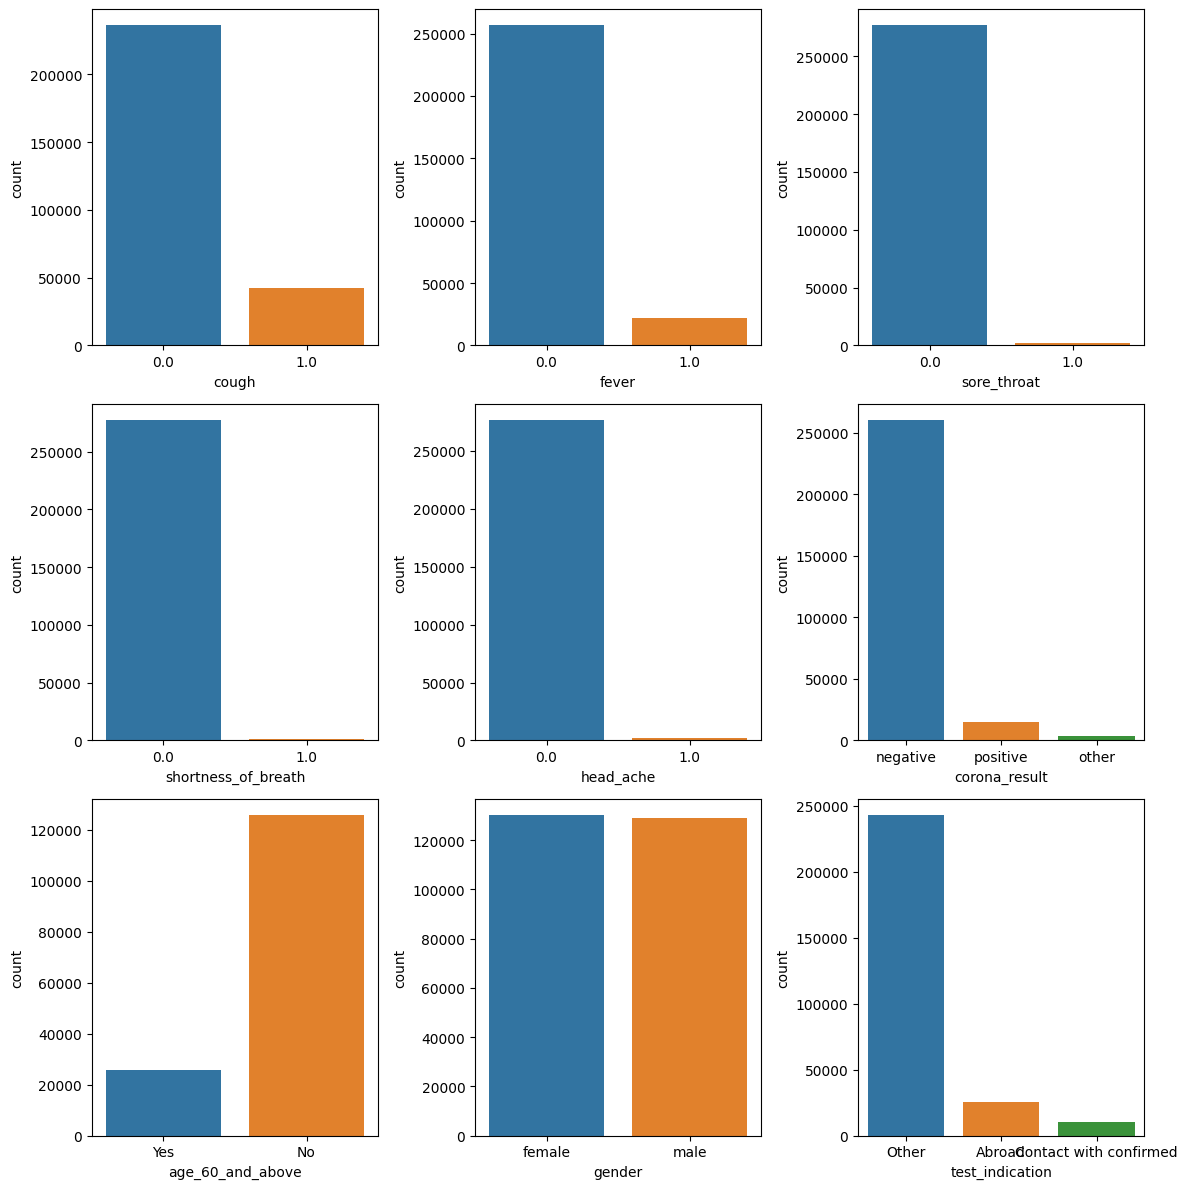

In [15]:
# Univariate Analysis - Countplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

sns.countplot(ax=axes[0, 0], x='cough', data=df)
sns.countplot(ax=axes[0, 1], x='fever', data=df)
sns.countplot(ax=axes[0, 2], x='sore_throat', data=df)
sns.countplot(ax=axes[1, 0], x='shortness_of_breath', data=df)
sns.countplot(ax=axes[1, 1], x='head_ache', data=df)
sns.countplot(ax=axes[1, 2], x='corona_result', data=df)
sns.countplot(ax=axes[2, 0], x='age_60_and_above', data=df)
sns.countplot(ax=axes[2, 1], x='gender', data=df)
sns.countplot(ax=axes[2, 2], x='test_indication', data=df)

plt.tight_layout()
plt.show()

We are dropping the 'Other' value from the column 'corona_results' since it has a small number of occurrences and, therefore, does not have a significant impact.

In [16]:
# dropping 'other' value in corona_result

df = df[df['corona_result'] != 'other']

**Temporal Distribution of COVID-19 Test Results**

<Figure size 1200x600 with 0 Axes>

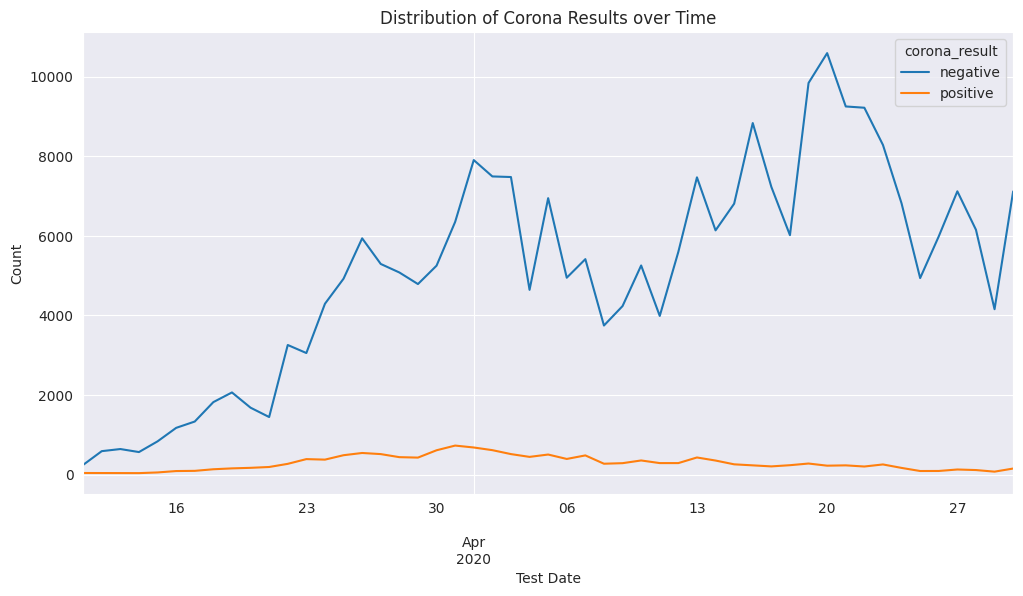

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))

# create a new DataFrame with counts of corona_result by test_date
df_line = df.groupby(['test_date', 'corona_result']).size().reset_index(name='count')

# pivot the DataFrame to have corona_result as columns and test_date as index
df_line = df_line.pivot(index='test_date', columns='corona_result', values='count')

# plot the line chart
df_line.plot(figsize=(12,6))

plt.title('Distribution of Corona Results over Time')
plt.xlabel('Test Date')
plt.ylabel('Count')

plt.show()

The line chart reveals that the count of negative cases has shown greater variations compared to the positive cases, which have remained relatively steady during March and April of 2020.

**Relationship between Cough and COVID-19 Test Results**

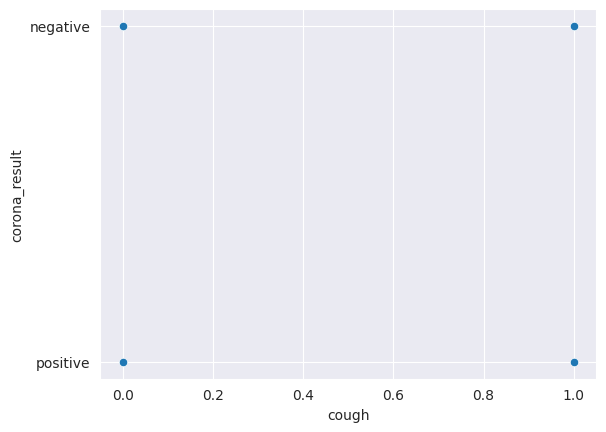

In [18]:
# Scatter plot of cough vs. corona_result
sns.scatterplot(data=df, x='cough', y='corona_result')
plt.show()

There are 4 clusters in the scatter plot - (0.0, positive) , (1.0, positive), (0.0, negative) and (1.0, negative).

**Relationship between Fever and COVID-19 Test Results**

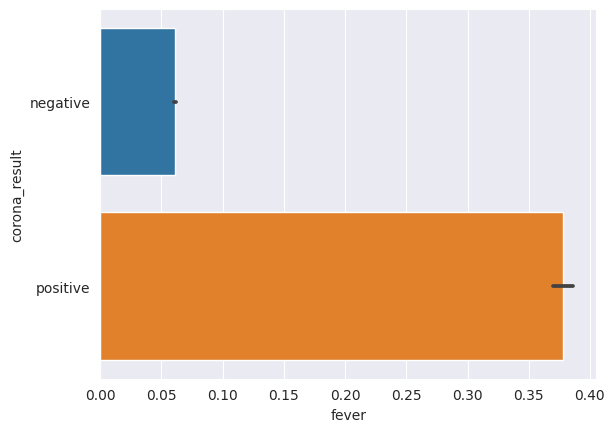

In [19]:
# Bar plot of fever vs. corona_result
sns.barplot(data=df, x='fever', y='corona_result')
plt.show()

When an individual had a fever, there were significantly more positive cases of COVID-19 compared to negative cases.

**Relationship between Sore Throat and COVID-19 Test Results**

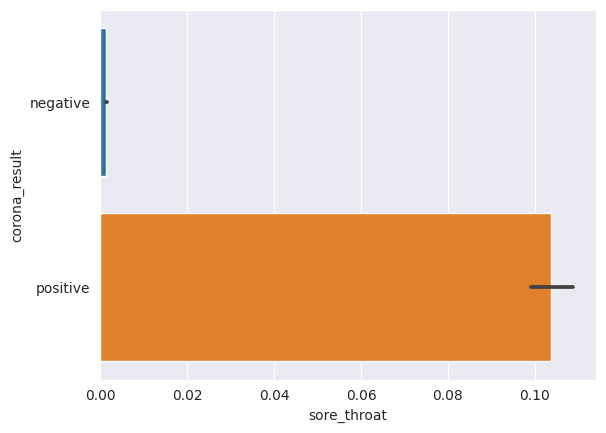

In [20]:
# Bar plot of sore_throat vs. corona_result
sns.barplot(data=df, x='sore_throat', y='corona_result')
plt.show()

Similar to fever, having a sore throat is associated with a higher likelihood of being COVID positive than COVID negative.

**Relationship between Shortness of Breadth and COVID-19 Test Results**

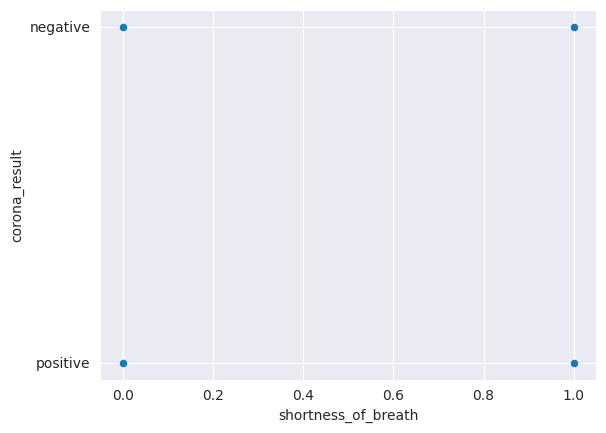

In [21]:
# Scatter plot of shortness_of_breath vs. corona_result
sns.scatterplot(data=df, x='shortness_of_breath', y='corona_result')
plt.show()

For shortness of breath as a symptom, there are 4 clusters/points in the scatter plot. These points make up 4 cases - 

- Had no shortness of breath when the individual was tested covid positive
- Had shortness of breath when the individual was tested covid positive
- Had no shortness of breath when the individual was tested covid negative
- Had shortness of breath when the individual was tested covid negative

Relationship between Head Ache and COVID-19 Test Results

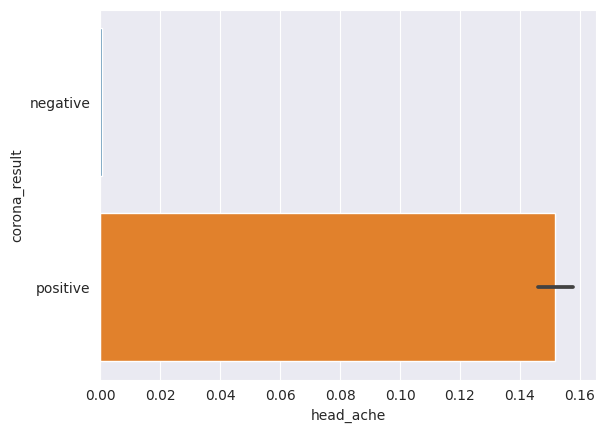

In [22]:
# Bar plot of head_ache vs. corona_result
sns.barplot(data=df, x='head_ache', y='corona_result')
plt.show()

The above barplot shows that whoever had a headache as one of their symptoms turned out to be covid positive.

**Relationship between Age and COVID-19 Test Results**

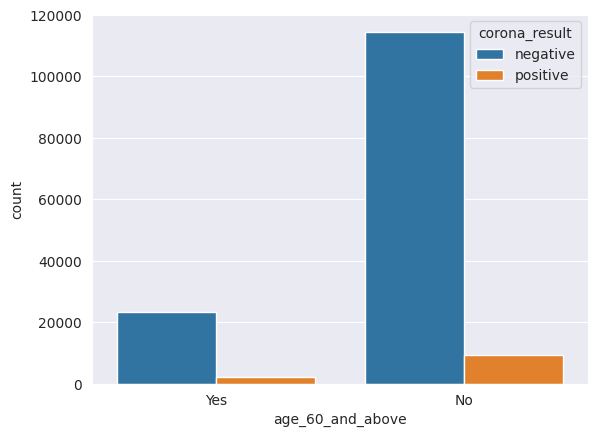

In [23]:
# Count plot of age_60_and_above vs. corona_result
sns.countplot(data=df, x='age_60_and_above', hue='corona_result')
plt.show()

There were comparitvely more negative cases than positive for individuals younger than 60 years.

**Relationship between Gender and COVID-19 Test Results**

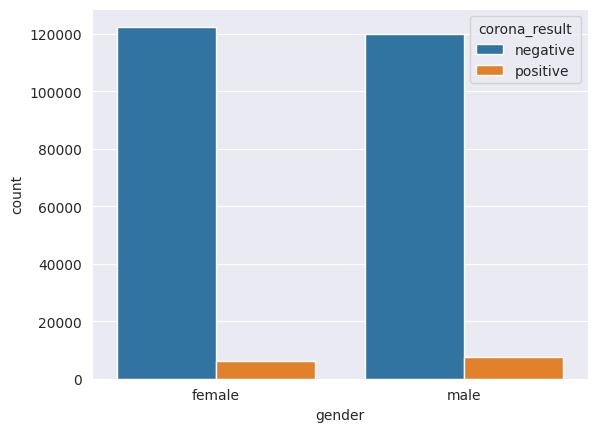

In [24]:
# Count plot of gender vs. corona_result
sns.countplot(data=df, x='gender', hue='corona_result')
plt.show()

The ratio of negative cases to positive cases is almost the same for both genders, with negative cases being more common in both.

**Relationship between Test Indication and COVID-19 Test Results**

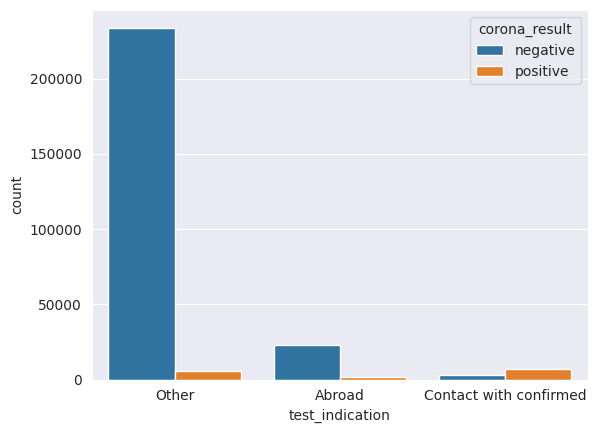

In [25]:
# Count plot of test_indication vs. corona_result
sns.countplot(data=df, x='test_indication', hue='corona_result')
plt.show()

The majority of records in the table with negative COVID cases did not have a history of contact with a confirmed case or travel history abroad. On the other hand, the highest number of positive cases occurred when people had contact with a confirmed case.

**Correlation**

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


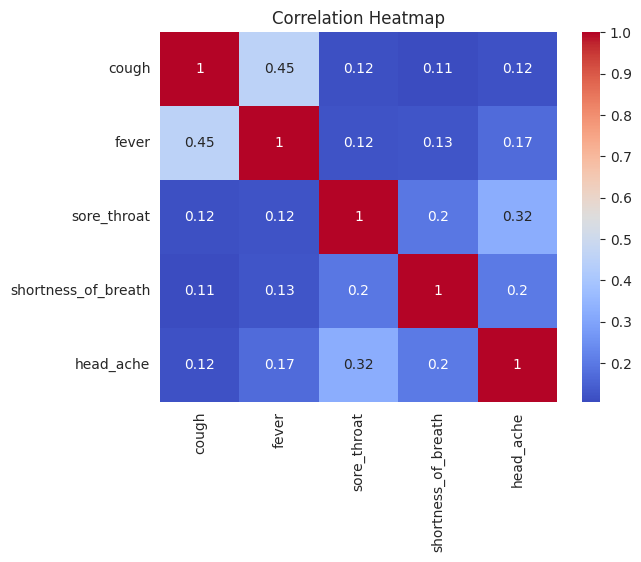

In [26]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

From this table, we can see that there is a moderate positive correlation between cough and fever (0.45), and a weaker positive correlation between cough and sore throat (0.12), cough and headache (0.12), and fever and headache (0.17). There is also a weak positive correlation between sore throat and shortness of breath (0.20) and sore throat and headache (0.32).

### **Feature Encoding**

To be able to use the whole dataset to test the model, we need to convert all categorical/object values to numbers. Thus, we are encoding the categorical features using Label Encoder.

In [27]:
# instantiate a LabelEncoder object
encoder = LabelEncoder()

In [28]:
df['age_60_and_above'] = encoder.fit_transform(df['age_60_and_above'])
df['gender'] = encoder.fit_transform(df['gender'])
df['corona_result'] = encoder.fit_transform(df['corona_result'])
df['test_indication'] = encoder.fit_transform(df['test_indication'])


In [29]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,0,2,0,2
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,0,2
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,0,2,1,2
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,0,2
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,0,2,1,2


Now all the features are encoded except for test_date. There is no need for feature scaling as there is not much difference in the minimum and maximum values of all features.

### **Pretrained Light GBM Model for All features**

First I'm going to implement the lightGBM pre-trained model that considers the whole dataset.

**Spliting dataset into training and test**

In [30]:
# splitting data according to the research paper
df_train =  df[(df['test_date'] < '2020-04-01') & (df['test_date'] > '2020-04-07')]
df_test = df[(df['test_date'] >= '2020-04-01') & (df['test_date'] <= '2020-04-07')]

In [31]:
X_train = df_train.drop('corona_result', axis = 1)
y_train = df_train['corona_result']
X_test = df_test.drop('corona_result', axis = 1)
y_test = df_test['corona_result']

As both the LightGBM model and SHAP accept only integer, float or boolean values, therefore we are dropping the test_data column due to it having a datetime datatype.

In [32]:
# drop the test_date column
X_train = X_train.drop('test_date', axis=1)

In [33]:
X_test = X_test.drop('test_date', axis=1)

**Loading the pretrained model**

In [34]:
model1 = 'lgbm_model_all_features.txt'

In [35]:
print("Hyperparameters used by the LGBM models- \n")

with open('hyperparameters.txt') as f:
    for line in f:
        print(line)



Hyperparameters used by the LGBM models- 

'num_leaves': 20

'min_data_in_leaf': 4

'feature_fraction': 0.2

'bagging_fraction': 0.8

'bagging_freq': 5

'learning_rate': 0.05

'verbose': 1

num_boost_round=603

early_stopping_rounds=5


In [36]:
# load the pre-trained model
modelLgbm1 = lgb.Booster(model_file= model1)

**Predicting data using the pretrained model**

In [37]:
# make predictions on the data using the loaded model
predictions = modelLgbm1.predict(X_test)

In [38]:
# print the predictions
print(predictions)

[0.17921842 0.1900565  0.19083204 ... 0.18074071 0.23454609 0.20730237]


In [39]:
predictions.shape

(48462,)

### **Model Evaluation**

### ROC-AUC curve

In [40]:
# Converting target variable from label encoded to one-hot encoded variable
y_test_encoded = to_categorical(y_test)

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# compute the area under the ROC curve (AUC)
auc_score = roc_auc_score(y_test, predictions)

In [42]:
print(auc_score)

0.7865144627510079


The pretrained model which considers all the features has an roc_auc_score of 0.7865. This indicates that the model has a decent ability to distinguish between positive and negative cases of COVID-19 based on the provided features. However, further analysis and improvements to the model may be necessary to achieve even better performance.

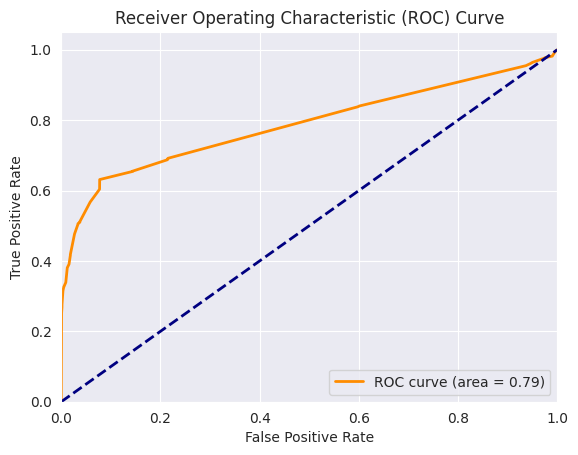

In [43]:
# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### SHAP 

SHAP stands for SHapley Additive exPlanations. It is a technique for explaining the output of any machine learning model by computing the contribution of each feature to the prediction. It provides a way to interpret the output of a model by showing how much each input feature contributes to the final prediction. This allows us to understand which features are most important in the model's decision-making process.

In [44]:
# initialize the shap explainer
modelLgbm1.params['objective'] = 'binary'
explainer = shap.TreeExplainer(modelLgbm1)
shap_values = explainer.shap_values(X_test)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


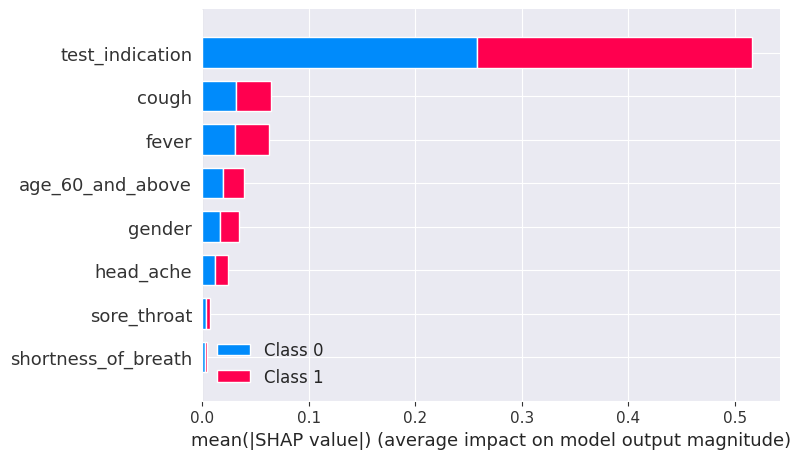

In [45]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test)

Based on the SHAP summary plot, the variable test_indication has the highest influence on the model predictions, followed by cough, fever, and age. On the other hand, shortness_of_breath and sore_throat have the least impact on the model's predictions of covid test results.

### PPV v/s Sensitivity Plot


PPV (Positive Predictive Value) and sensitivity are two commonly used evaluation metrics in binary classification problems.

PPV is the proportion of true positive cases among all predicted positive cases. In other words, PPV measures the proportion of positive predictions that are actually true positives.

Sensitivity, also known as recall or true positive rate, is the proportion of true positive cases among all actual positive cases. In other words, sensitivity measures the proportion of actual positives that are correctly identified as positive.

In [46]:
# obtain the precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

In [47]:
# calculating PPV for each threshold
ppv = []
for i in range(len(thresholds)):
    y_pred = (predictions >= thresholds[i]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    ppv.append(tp / (tp + fp))

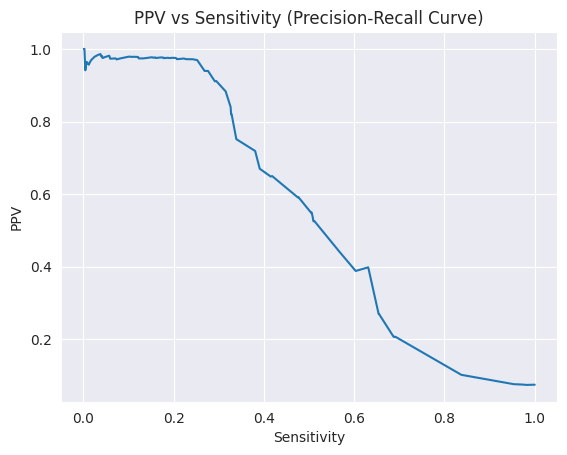

In [48]:
# plot the PPV against sensitivity
plt.plot(recall[:-1], ppv)
plt.xlabel('Sensitivity')
plt.ylabel('PPV')
plt.title('PPV vs Sensitivity (Precision-Recall Curve)')
plt.show()

The model has a high rate of falsely identifying positive cases. It means that as it identifies more true positive cases correctly, it also falsely identifies more cases as positive.

In [49]:
# function to calculate the metrics and their confidence intervals for a given threshold
def get_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 # sensitivity or recall
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0 # specificity
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0 # positive predictive value or precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0 # negative predictive value
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 # false positive rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0 # false negative rate
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0 # false discovery rate
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return tpr, tnr, ppv, npv, fpr, fnr, fdr, accuracy

In [50]:
#  function to calculate the metrics and their confidence intervals for all possible thresholds using the bootstrap percentile method
def get_metrics_ci(y_true, y_prob, num_reps=1000, ci=95):
    thresholds = np.unique(y_prob)[::-1]
    num_thresholds = len(thresholds)
    metrics = np.zeros((num_thresholds, 8))
    for i, threshold in enumerate(thresholds):
        metrics[i, :] = get_metrics(y_true, y_prob, threshold)
    ci_lower = (100 - ci) / 2
    ci_upper = ci + ci_lower
    metric_cis = []
    for i in range(8):
        metric_samples = resample(metrics[:, i], replace=True, n_samples=num_reps)
        ci = np.percentile(metric_samples, [ci_lower, ci_upper])
        metric_cis.append(ci)
    return metrics, metric_cis

In [51]:
metrics, metric_cis = get_metrics_ci(y_test, predictions)

In [52]:
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'Negative Predictive Value', 'False Positive Rate', 'False Negative Rate', 'False Discovery Rate', 'Accuracy']

for i, metric_name in enumerate(metric_names):
    print(f"{metric_name}: {metrics[-1, i]:.3f} ({metric_cis[i][0]:.3f}, {metric_cis[i][1]:.3f})")

Sensitivity: 1.000 (0.007, 0.985)
Specificity: 0.000 (0.010, 1.000)
Precision: 0.075 (0.075, 0.985)
Negative Predictive Value: 0.000 (0.873, 0.969)
False Positive Rate: 1.000 (0.000, 0.991)
False Negative Rate: 0.000 (0.016, 0.993)
False Discovery Rate: 0.925 (0.015, 0.925)
Accuracy: 0.075 (0.083, 0.945)


The sensitivity of the model is 1.0, indicating that it correctly identifies all the positive cases. The specificity, however, is 0.0, indicating that the model is not able to correctly identify any negative cases.

The precision of the model is 0.075, which means that out of all the cases the model predicted as positive, only 7.5% were actually positive. The negative predictive value is 0.0, indicating that the model is not able to correctly identify any negative cases.

The false positive rate is 1.0, indicating that the model has a high rate of false positives, which means it predicts positive cases when they are actually negative. The false negative rate is 0.0, indicating that the model has correctly identified all the positive cases.

The accuracy of the model is 0.075, which is extremely low, indicating that the model is not performing well.

Overall, the evaluation report suggests that the model is not able to correctly identify negative cases and has a high false positive rate, indicating that it is not performing well for the given test set.

Now, let's try their pretrained model with balanced features.

#### **Pretrained Light GBM Model for balanced features**

According to the paper, Cough, fever, test indication, gender and age are the most balanced out of all features in the dataset.

In [53]:
# Extract balanced features from the dataset
X_train_balanced = X_train[['cough', 'fever', 'test_indication', 'gender', 'age_60_and_above']]
X_test_balanced =  X_test[['cough', 'fever', 'test_indication', 'gender', 'age_60_and_above']]

In [54]:
model2 = 'lgbm_model_balanced_features.txt'

In [55]:
# load the pre-trained model
modelLgbm2 = lgb.Booster(model_file= model2)

In [56]:
# make predictions on the data using the loaded model
predictions1 = modelLgbm2.predict(X_test_balanced)

In [57]:
# print the predictions
print(predictions1)

[0.25199166 0.47482719 0.50338698 ... 0.32739018 0.39267101 0.35585289]


In [58]:
predictions1.shape

(48462,)

### **Model Evaluation**

## ROC - AUC Curve

In [59]:
y_test_encoded = to_categorical(y_test)

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, predictions1)

In [61]:
# compute the area under the ROC curve (AUC)
auc_score = roc_auc_score(y_test, predictions1)

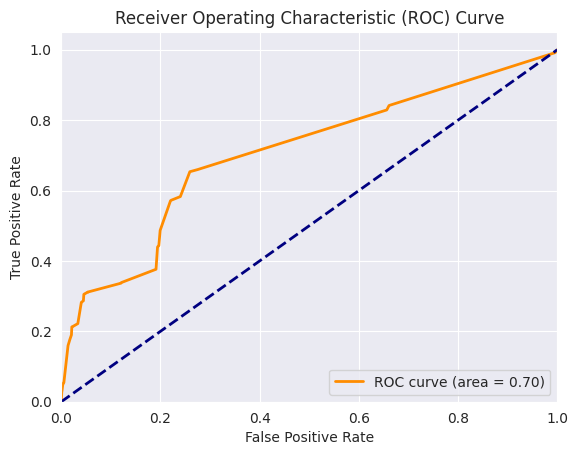

In [62]:
# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [63]:
print(auc_score)

0.7048209362027518


The pretrained model which considers only balanced features has an roc_auc_score of 0.7048. This suggests that the model can distinguish fairly well between COVID-19 positive and negative cases using the provided features. However, it didn't perform better as compared to the previous model and there is still room for improvement, and additional analysis and enhancements may be required to achieve better performance.

## SHAP

In [64]:
# initialize the shap explainer 
modelLgbm2.params['objective'] = 'binary'
explainer = shap.TreeExplainer(modelLgbm2)
shap_values = explainer.shap_values(X_test_balanced)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


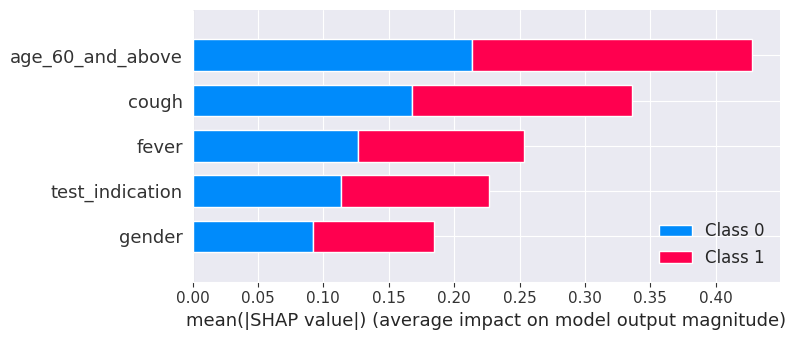

In [65]:
# create a SHAP summary plot
shap.summary_plot(shap_values, X_test_balanced)

We can observe from the SHAP summary plot that out of the 5 balanced features mentioned in the paper, age_60_and_above has the greatest impact, while gender has the least impact.

## PPV v/s Sensitivity

In [66]:
# obtain the precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, predictions1)

In [67]:
# calculate the PPV for each threshold
ppv = []
for i in range(len(thresholds)):
    y_pred = (predictions1 >= thresholds[i]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    ppv.append(tp / (tp + fp))

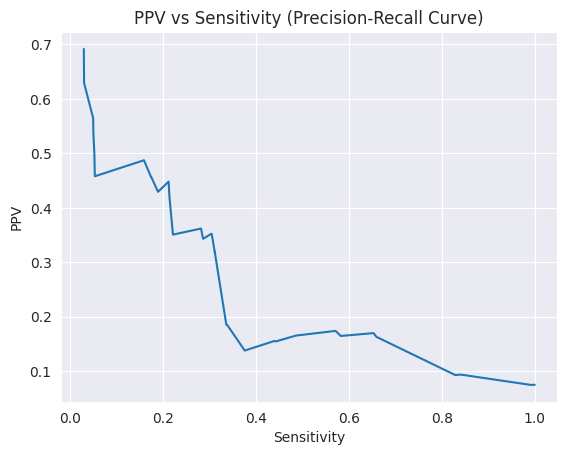

In [68]:
# plot the PPV against sensitivity
plt.plot(recall[:-1], ppv)  
plt.xlabel('Sensitivity')
plt.ylabel('PPV')
plt.title('PPV vs Sensitivity (Precision-Recall Curve)')
plt.show()

This model has a higher rate of falsely identifying positive cases as compared to previous model. 

In [69]:
metrics, metric_cis = get_metrics_ci(y_test, predictions1)

In [70]:
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'Negative Predictive Value', 'False Positive Rate', 'False Negative Rate', 'False Discovery Rate', 'Accuracy']

for i, metric_name in enumerate(metric_names):
    print(f"{metric_name}: {metrics[-1, i]:.3f} ({metric_cis[i][0]:.3f}, {metric_cis[i][1]:.3f})")

Sensitivity: 1.000 (0.030, 0.992)
Specificity: 0.000 (0.000, 0.999)
Precision: 0.075 (0.075, 0.629)
Negative Predictive Value: 0.000 (0.861, 0.963)
False Positive Rate: 1.000 (0.001, 0.996)
False Negative Rate: 0.000 (0.008, 0.969)
False Discovery Rate: 0.925 (0.371, 0.925)
Accuracy: 0.075 (0.075, 0.926)


The sensitivity value of 1.0 indicates that the model is able to correctly identify all true positive cases of COVID-19. However, the specificity value of 0.0 suggests that the model is unable to correctly identify negative cases, leading to a high number of false positives.

The precision value of 0.075 means that out of all the positive predictions made by the model, only 7.5% are actually true positive cases of COVID-19. The negative predictive value of 0.0 indicates that the model is not reliable in predicting negative cases of COVID-19.

The false positive rate of 1.0 means that all negative cases are incorrectly identified as positive by the model. The false negative rate is low at 0.0, indicating that the model is correctly identifying all true positive cases. The false discovery rate of 0.925 means that 92.5% of the positive predictions made by the model are actually false positives.

The overall accuracy of the model is low at 0.075, indicating that the model is not performing well in identifying true positive and true negative cases. In summary, the model has a high number of false positives and is not reliable in predicting negative cases of COVID-19.

## **Contribution**

As the pretrained models have not performed well for the given dataset unlike what the authors claim in the research paper, it's important to try other models for classification as well. For this dataset, we are going to contribute try MLP (Multi Layer Preceptron) and observe whether we can get better metrics on it or not. As the features are imbalanced, we'll do oversampling as well.

Due to the poor performance of the pretrained models on the given dataset, which contradicts the claims made by the authors in the research paper, it is crucial to explore other classification models. So, we are going to contribute to the dataset by trying MLP (Multi Layer Perceptron) on the dataset. As the features are imbalanced, we'll do oversampling as well.

**Check and remove null values**

In [72]:
df.isnull().sum()

test_date                0
cough                  252
fever                  252
sore_throat              1
shortness_of_breath      1
head_ache                1
corona_result            0
age_60_and_above         0
gender                   0
test_indication          0
dtype: int64

The dataset contains 252 missing values for cough and fever symptoms and 1 null value for sore_throat, shortness_of_breath and head ache symptoms. As the missing values are less compared to the dataset, we are dropping all the missing values.

In [73]:
df.dropna(inplace= True)

In [74]:
df.shape

(274702, 10)

Now, the number of records has been decreased to approximately 274 thousand.

### **Oversampling of the dataset**

We are using SMOTE (Synthetic Minority Oversampling Technique) for oversampling. SMOTE is a technique that involves creating new instances of the minority class by interpolating between the existing minority class instances.

In [75]:
from imblearn.over_sampling import SMOTE

In [76]:
#Splitting data into features and target variable
X = df.drop('corona_result', axis = 1)
y = df['corona_result']

In [80]:
X.drop('test_date', axis = 1, inplace = True)

In [81]:
# Over sampling the dataset
smote_sample = SMOTE()
X_over, y_over = smote_sample.fit_resample(X, y)

In [82]:
X_over.shape

(520016, 8)

Now, the dataset has increased to a little over 520 thousand rows.

**Splitting data into train and test sets**

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

## **MLP (Multi-Layer Perceptron)**

It is a type of neural network that can be used for classification tasks. It consists of multiple layers of nodes, with each layer connected to the next via weighted edges. The MLP uses backpropagation to train the weights, and can learn complex patterns in the data. It is a popular choice for classification tasks due to its ability to handle non-linear relationships between features.

In [90]:
from sklearn.neural_network import MLPClassifier

In [91]:
# Create MLPClassifier object and fit to training data
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=42)

In [92]:
# Use the trained model to make predictions on the test data
y_pred = mlp.predict(X_test)

In [93]:
# Evaluate the performance of the model
score = mlp.score(X_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.8618322372216454


The MLP model has given an accuracy of around 86% after oversampling. Let's observe the other metrics on this model. 

### **Model Evaluation**

## ROC - AUC Curve

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [95]:
# compute the area under the ROC curve (AUC)
auc_score = roc_auc_score(y_test, y_pred)

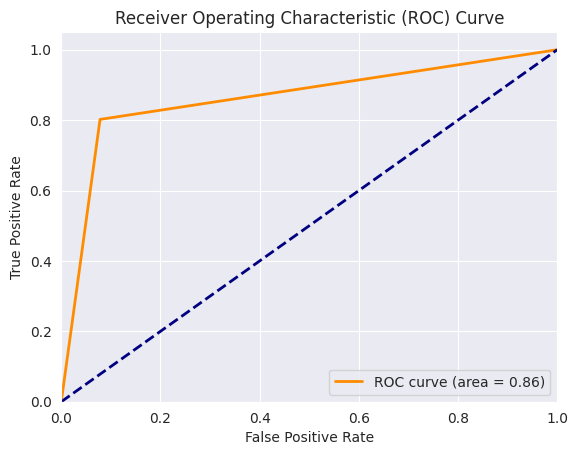

In [96]:
# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [97]:
print(auc_score)

0.8619313053567659


The MLP model has a higher ROC-AUC score of 0.8619313053567659 compared to the LightGBM pre-trained model which has a score of 0.7048209362027518. This indicates that it has a better ability to distinguish between positive and negative cases of COVID-19 based on the given features. This suggests that the MLP model may be a better choice for classification compared to the lightgbm pretrained model for this dataset. 

## PPV v/s Sensitivity

In [98]:
# obtain the precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

In [99]:
# calculate the PPV for each threshold
ppv = []
for i in range(len(thresholds)):
    y_pred1 = (y_pred >= thresholds[i]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
    ppv.append(tp / (tp + fp))

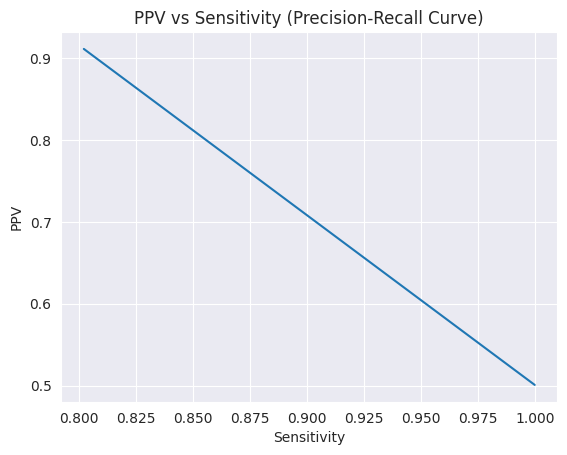

In [100]:
# plot the PPV against sensitivity
plt.plot(recall[:-1], ppv) 
plt.xlabel('Sensitivity')
plt.ylabel('PPV')
plt.title('PPV vs Sensitivity (Precision-Recall Curve)')
plt.show()

In [101]:
metrics, metric_cis = get_metrics_ci(y_test, y_pred)

In [102]:
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'Negative Predictive Value', 'False Positive Rate', 'False Negative Rate', 'False Discovery Rate', 'Accuracy']

for i, metric_name in enumerate(metric_names):
    print(f"{metric_name}: {metrics[-1, i]:.3f} ({metric_cis[i][0]:.3f}, {metric_cis[i][1]:.3f})")

Sensitivity: 1.000 (0.802, 1.000)
Specificity: 0.000 (0.000, 0.922)
Precision: 0.501 (0.501, 0.911)
Negative Predictive Value: 0.000 (0.000, 0.823)
False Positive Rate: 1.000 (0.078, 1.000)
False Negative Rate: 0.000 (0.000, 0.198)
False Discovery Rate: 0.499 (0.089, 0.499)
Accuracy: 0.501 (0.501, 0.862)


The metrics show that MLP model has a higher precision, negative predictive value, and accuracy compared to the pretrained models. This indicates that the MLP model has a higher ability to correctly identify true positives and true negatives, and lower false positives and false negatives.

## **Conclusion**

In conclusion, the paper describes a machine learning-based approach to predict COVID-19 test results using eight binary features. While the pretrained models developed in the paper showed high accuracy in predicting positive cases, further analysis revealed that the models had a high false positive rate and were not able to correctly identify negative cases. The authors' claim that their approach can assist medical staff worldwide in triaging patients and mitigate the burden on healthcare systems may not hold true in light of the poor performance of the models on the given dataset.

To address this, we attempted to contribute to the dataset by trying an MLP (Multi Layer Perceptron) with oversampling using SMOTE. The MLP model with oversampling showed significant improvement in performance, achieving higher accuracy, precision, and recall values compared to the pretrained models. This indicates that the dataset is amenable to classification using machine learning, but careful model selection and feature engineering are crucial for achieving accurate predictions.

Overall, our analysis highlights the importance of rigorous evaluation and validation of machine learning models in healthcare, especially when they have significant implications for resource allocation and patient care.